# LSTM Network 

This code is for an LSTM from scratch and accompanies the blog post.

First we will import our dependencies - the bulk of which are for reading in and processing the training data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm  import tqdm_notebook #used for loading bar (e.g. to visualise how long an operation is taking)

#read in data
import requests #get from url
import tarfile #to extract zip/tar
import zipfile
import os
import regex as re #to clean the text
import string

### Preprocessing the Input

First let's define a helper function to download a file from a url. 
We will use this to download the IMDB reviews dataset which we will be training an LSTM on for sentiment analysis, and also to download the pretrained GloVe word embeddings.

In [2]:
def maybe_download(data_url, path):
    if os.path.exists(os.getcwd()+"/"+path): #so we don't re-download a file when we re-run the notebook
        print("Data already present.")
    else:
        print("Downloading data...")
        r = requests.get(data_url, stream=True) #GET request from URL, we do in chunks so that we can monitor progress
        file_name = data_url.split("/")[-1] #the end of the url gives the file name
        with open(file_name,'wb') as f:
            total_length = int(r.headers.get('content-length'))
            for chunk in tqdm_notebook(r.iter_content(chunk_size=8192), total=(total_length//8192) + 1): 
                if chunk:
                    f.write(chunk)
                    f.flush()
        print("Extracting data...")
        if "tar" in file_name:
            unzipper = tarfile.open(file_name)
        elif "zip" in file_name:
            unzipper = zipfile.ZipFile(file_name,"r")
        unzipper.extractall()
        unzipper.close()
        os.remove(path) #remove the zip/tar.gz file now that its contents have been extracted
        print("Success: Data downloaded and extracted.")

In [3]:
maybe_download(data_url="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", path="aclImdb")

Data already present.


In [4]:
maybe_download(data_url="http://nlp.stanford.edu/data/wordvecs/glove.6B.zip", path="glove.6B.50d.txt")

Data already present.


Now we will create a dictionary that maps from words to their respective embeddings.

In [5]:
def get_GloVe_vecs(embedding_size):
    file_name = "glove.6B." + str(embedding_size) + "d.txt"
    with open(file_name,'r') as f:
        word_to_glove = {}
        for line in f: #each line contains a word followed by each dimension of the embedding
            line =line.strip().split() #remove trailing whitespace and split on spaces
            word = line[0]
            vec = np.array(line[1:], dtype=np.float64)
            word_to_glove[word]= vec #map word to vector
    return word_to_glove



Next let's go through the text files and extract the input features using this word_to_glove dictionary.
We use 3 special one-hot embeddings for the 3 special tokens - **START, END** and **PAD**. 

Note **PAD** is used so we can process the files in batches - they need to have the same dimensions for matrix multiplication. 

In [6]:
def clean_line(s):
    s = s.lower() #convert to lower-case 
    return re.sub('[%s]' % re.escape(string.punctuation), '', s) #remove punctuation from line

def preprocess_input(path,embedding_size,max_length):
    word_to_glove = get_GloVe_vecs(embedding_size)
    X = np.zeros((25000,embedding_size+3,max_length)) #first 3 dimensions are reserved for special tokens.
    Y = np.zeros((1,25000))
    reviews = [] #track file associated with respective input features 
    Y[:,:12500] =1 #positive reviews
    for k,label in enumerate(["pos", "neg"]): #go through reviews first in pos directory then in neg directory
        for i, file in enumerate(tqdm_notebook(os.listdir(os.fsencode(path+'/'+label)), total=12500)):
            filename = os.fsdecode(file)
            with open(path+'/'+label+'/'+filename, 'r') as f:
                X[k*12500+i,0,0] =1 #START OF SENTENCE token
                num_words=1 #keep track of number of words read in 
                reviews.append(path+'/'+label+'/'+filename) #store the file path of the review
                for line in f:
                    line = clean_line(line)
                    for word in line.strip().split():
                        if num_words>=(max_length-1): #we've reached max input length 
                            break
                        if word in word_to_glove.keys(): #ignore words that don't have an embedding
                            X[k*12500+i,3:,num_words] = word_to_glove.get(word) #first 12500 are pos, second 12500 are neg
                            num_words+=1
                    if num_words>=(max_length-1):
                        break
                X[k*12500+i,2,num_words:max_length-1] = 1 #PAD token for reviews shorter than the max length
                X[k*12500+i,1,-1] = 1 #last embedding is END OF SENTENCE token
    
    #shuffle indices
    idx = np.random.permutation(25000)
    X = X[idx]
    Y = Y[:,idx]
    reviews = np.array(reviews)[idx]
    return X, Y,reviews

In [7]:
X_train, Y_train,train_reviews = preprocess_input('aclImdb/train/', embedding_size=100,max_length=200)
X_test, Y_test, test_reviews = preprocess_input('aclImdb/test/', embedding_size=100,max_length=200)


Let's have a look at a sample review in our training set.

In [8]:
i = np.random.randint(0,25000)
print((Y_train[:,i]))
with open(train_reviews[i],'r') as f:
    for line in f:
        print(line)

[0.]
Yes AWA wrestling how can anyone forget about this unreal show. First they had a very short interviewer named Marty O'Neil who made "Rock n Roll" Buck Zumhofe look like a nose tackle. Then it was Gene Okerland who when he got "mad as the wrestler" would say either "Were out of time" or "Well be right back" acting like he was mad but actually sounding forced. After he went to the WWF Ken Resneck took over even though his mustache looked like week old soup got stuck to it was a very fine interviewer who "Georgeous" Jimmy Garvin called mouse face which made me fall off my chair laughing. After he jumped ship then Larry Nelson came on board which he was so bad that Phyllis George would of been an improvement! Then there's Doug McLeod the best wrestling announcer ever who made every match exciting with his description of blows! Then he was offered more pay by the Minnesota North Stars hockey team. At ringside who can forget Roger Kent who's mispronouncing of words and sentences were hi

### Training the model

Now, having preprocessed the input, we can define the LSTM model we are training. 
We will define functions for the forward and backward steps, then we can unroll the network as a sequence of forward steps / backward steps, for the forward/back propagation functions respectively.

Note since the equations for the gates are identical, differing only in the weights used, we can combine them into one large matrix multiply.

The equations for the forward step are:

$$ \tilde{c}^{<t>} =\tanh (W_c [a^{<t-1>}, x^{<t>}]+b_c) $$
$$ \Gamma = \sigma(W_g [a^{<t-1>}, x^{<t>}]+b_g)$$
$$  {c}^{<t>} = \Gamma_i*\tilde{c}^{<t>} + \Gamma_f*{c}^{<t-1>}$$
$$ a^{<t>} = \Gamma_o*\tanh{c}^{<t>}$$
    
And the equations for the backward step are:

$$ \frac{\partial{J}}{\partial{c^{<t>}}} = \frac{\partial{J}}{\partial{c^{<t+1>}}}*\Gamma_f + 
   \frac{\partial{J}}{\partial{a^{<t>}}}*\Gamma_o *(1-\tanh^2{c}^{<t>})$$
$$ \frac{\partial{J}}{\partial{\tilde{c}^{<t>}}} = \frac{\partial{J}}{\partial{c^{<t>}}}*\Gamma_i $$

$$ \frac{\partial{J}}{\partial{\Gamma_i}}= \frac{\partial{J}}{\partial{{c}^{<t>}}}*\tilde{c}^{<t>}$$

$$ \frac{\partial{J}}{\partial{\Gamma_f}}= \frac{\partial{J}}{\partial{{c}^{<t>}}}*{c}^{<t-1>}$$

$$ \frac{\partial{J}}{\partial{\Gamma_o}}= \frac{\partial{J}}{\partial{{a}^{<t>}}}*\tanh{c}^{<t>}$$

$$ \frac{\partial{J}}{\partial{Z_g}} = \frac{\partial{J}}{\partial{\Gamma}}*\Gamma*(1-\Gamma)$$

$$ \frac{\partial{J}}{\partial{W_g}} = \frac{1}{m} \frac{\partial{J}}{\partial{Z_g}}.[a^{<t-1>}, x^{<t>}]^T $$

$$ \frac{\partial{J}}{\partial{b_g}} = \frac{1}{m}\sum_{i=1}^{m} \frac{\partial{J}}{\partial{Z_g^{(i)}}} $$


$$ \frac{\partial{J}}{\partial{Z_c}} = \frac{\partial{J}}{\partial{\tilde{c}^{<t>}}}*(1-\tilde{c}^{<t>^2})$$

$$ \frac{\partial{J}}{\partial{W_c}} = \frac{1}{m} \frac{\partial{J}}{\partial{Z_c}}.[a^{<t-1>}, x^{<t>}]^T $$

$$ \frac{\partial{J}}{\partial{b_c}} = \frac{1}{m}\sum_{i=1}^{m} \frac{\partial{J}}{\partial{Z_c^{(i)}}} $$


$$ \frac{\partial{J}}{\partial{[a^{<t-1>}, x^{<t>}]}} =  W_g^T.\frac{\partial{J}}{\partial{Z_g}}+     W_c^T.\frac{\partial{J}}{\partial{Z_c}} $$



In [9]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))


def forward_step(a_prev, x, c_prev, parameters):
    n_a = a_prev.shape[0]
    input_concat = np.concatenate((a_prev, x),axis=0)
    IFO_gates = sigmoid(parameters["Wg"].dot(input_concat)+parameters["bg"])
    c_candidate = np.tanh(parameters["Wc"].dot(input_concat)+parameters["bc"])
    c_next = IFO_gates[:n_a]*c_candidate + IFO_gates[n_a:2*n_a]*c_prev
    a_next = IFO_gates[2*n_a:]*np.tanh(c_next)
    cache = (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates)
    return a_next, c_next, cache


def backward_step(dA_next, dC_next,cache,parameters):
    (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates) = cache
    n_a, m = a_next.shape
    
    dC_next += dA_next* (IFO_gates[2*n_a:]*(1-np.tanh(c_next)**2)) 
    #we compute dC<t> in two backward steps since we need both dC<t+1> and dA<t>
    
    dC_prev = dC_next * IFO_gates[n_a:2*n_a] 
    dC_candidate =  dC_next * IFO_gates[:n_a]
    
    #derivative with respect to the output of the IFO gates - abuse of notation to call it dIFO
    dIFO_gates = np.zeros_like(IFO_gates)
    dIFO_gates[:n_a] = dC_next * c_candidate 
    dIFO_gates[n_a:2*n_a]= dC_next * c_prev
    dIFO_gates[2*n_a:] = dA_next * np.tanh(c_next)
    
    #derivative with respect to the unactivated output of the gate (before the sigmoid is applied)
    dZ_gate =  dIFO_gates* (IFO_gates*(1-IFO_gates))   
    dA_prev =  (parameters["Wg"].T).dot(dZ_gate)[:n_a]
    dWg = (1/m)*dZ_gate.dot(input_concat.T)
    dbg = (1/m)*np.sum(dZ_gate,axis=1, keepdims=True)
    
    dZ_c = dC_candidate * (1-c_candidate**2)
    dA_prev +=  (parameters["Wc"].T).dot(dZ_c)[:n_a]
    dWc = (1/m)*dZ_c.dot(input_concat.T)
    dbc = (1/m)*np.sum(dZ_c,axis=1, keepdims=True)  
    
    return dA_prev, dC_prev, dWg, dbg, dWc, dbc



Now to define the entire forward and backward propagation functions:

This is just iterating over the forward and backward steps, with the only difference being the output layer, which is just a *logistic regression* layer and a *L2 regularisation* term in the backprop step.
The equation for this layer is:
        $$ {y}_{pred} = \sigma(W_y.a^{<T_x>}+b_y)$$
$$\frac{\partial{J}}{\partial{Z_y}} =(y^{(i)}_{pred} - y^{(i)})$$
$$\frac{\partial{J}}{\partial{W_y}} =  \frac{1}{m} a^{<T_x>}\frac{\partial{J}}{\partial{Z_y}}$$
$$\frac{\partial{J}}{\partial{b_y}} =  \frac{1}{m} \sum_{i=1}^{m}\frac{\partial{J}}{\partial{Z^{(i)}_y}} $$
$$ \frac{\partial{J}}{\partial{a^{<T_x>}}} =  W_y^T.\frac{\partial{J}}{\partial{Z_y}} $$


In [10]:
def forward_prop(X, parameters):
    m, _, Tx = X.shape
    a = np.repeat(parameters["a0"],m, axis=1)
    c = np.repeat(parameters["c0"],m, axis=1)
    caches= [] #store intermediate values for each timestep
    for t in range(Tx):
        xt = np.squeeze(X[:,:,t]).T #so 2D matrix n_x, m
        a, c, cache = forward_step(a,xt , c, parameters)
        caches.append(cache)
    y_pred = sigmoid(parameters["Wy"].dot(a)+parameters["by"])
    return y_pred, caches


def backprop(X,y, y_pred, parameters, caches,lambd):
    m, _, Tx = X.shape
    grads = {}
    
    
    dZ_pred = (y_pred-y) 
    dA =  (parameters["Wy"].T).dot(dZ_pred)
    grads["dWy"] = (1/m)*dZ_pred.dot(caches[Tx-1][0].T) #this is A<T_X>
    grads["dby"] = (1/m)*np.sum(dZ_pred,axis=1, keepdims=True)
    
    dC = np.zeros_like(dA)
    
    grads["dWg"] = np.zeros_like(parameters["Wg"])
    grads["dbg"] = np.zeros_like(parameters["bg"])
    grads["dWc"] = np.zeros_like(parameters["Wc"])
    grads["dbc"] = np.zeros_like(parameters["bc"])
    
    
    for t in reversed(range(Tx)):
        (dA, dC, dWg, dbg, dWc, dbc) = backward_step(dA, dC, caches[t],parameters)
        grads["dWg"] += dWg
        grads["dbg"] += dbg
        grads["dWc"] += dWc
        grads["dbc"] += dbc
    
    grads["da0"] = np.sum(dA,axis=1,keepdims=True)
    grads["dc0"] = np.sum(dC,axis=1,keepdims=True)
    
    #regularisation term
    for key in grads:
        if "W" in key:
            grads[key]+= (lambd/m)*parameters[key[1:]] #key is dW___ so key[1:] is W___
    
    return grads


The loss function is binary cross-entropy - i.e. the same as logistic regression - with an L2 regularisation term.

$$J(W_y, b_y,...) = = \frac{-1}{m} \sum_{i=1}^{m} y^{(i)} \log(y^{(i)}_{pred}) + (1-y^{(i)}) \log(1-y^{(i)}_{pred}) + \frac{\lambda}{2m}\sum_W  \left\| W \right\|^2$$


In [11]:
def loss_function(y_pred,y, parameters, lambd):
    m = y.shape[1]
    cost = (-1/m)*np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
    
    regularisation_term = 0
    for key in parameters:
        if "W" in key:
            regularisation_term += np.sum(np.square(parameters[key]))
    
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    
    return regularised_cost


We can also define helper functions to help evaluate the model's performance during training: 
   
To check the backpropagation calculation is correct, we can numerically approximate the gradient at that point and compare it to the network's backprop gradient. We sample multiple neurons in the layer and average this, then compare relative error:

If the parameter we are perturbing is $p_i$ (could be a weight or a bias) then we use:

$$ \frac{\partial{J}}{\partial{p_i}} = \frac{J(..,p_i+\epsilon,..) - J(..,p_i-\epsilon,.)}{2 \epsilon} $$

to compute the gradient with respect to the parameter. 

The forward checker just prints out parameter values to inspect manually, e.g to see if sigmoid/tanh outputs are saturating or if weights are too large.

In [12]:
def accuracy(y_pred,y):
    preds = np.rint(y_pred) #round to int
    return np.mean(np.equal(preds,y).astype(int))

In [13]:
def backprop_checker(parameters,grads, x, y,lambd):
    epsilon = 1e-7
    rel_threshold = 1e-2
    num_sample = 10
    flag = True #if backprop is correct
    print("Checking gradients...")
    for param in parameters.keys(): 
        print("Checking: " + param)
        dims = parameters[param].shape
        
        
        num_grad = 0
        backprop_grad = 0
        
        for _ in range(num_sample): #sample 10 neurons
            idx = np.zeros(len(dims))
            for i in range(len(dims)):
                idx[i] = np.random.randint(0,dims[i])
            idx = tuple(idx.astype(int))

            parameters[param][idx]= parameters[param][idx] + epsilon
            y_pred_plus = forward_prop(x,parameters)[0]
            J_plus = loss_function(y_pred_plus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx] - 2*epsilon

            y_pred_minus = forward_prop(x,parameters)[0]

            J_minus = loss_function(y_pred_minus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx]+ epsilon

            num_grad += (J_plus-J_minus)/(2*epsilon)
            backprop_grad += grads["d"+param][idx]
            
            
        num_grad/=num_sample
        backprop_grad/=num_sample
        rel_error = abs((num_grad-backprop_grad)/num_grad)
        if rel_error>rel_threshold:
            #print("J_plus: "+ str(J_plus))
            #print("J_minus: "+ str(J_minus))
            print("Numerical grad:" + str(num_grad))
            print("Backprop grad:" + str(backprop_grad))
 
            print("Relative error: " + str(rel_error))
            if not (num_grad<1e-6 and backprop_grad<1e-6): 
                #for very small values the relative error is affected by floating point error so is not reliable
                flag = False
                print("Backprop calculation incorrect")
    print("Gradient check complete")
    assert(flag) #if not the backprop is massively out so kill training

In [14]:
def forward_checker(caches):
    for i, cache in enumerate(caches):
        n_a = cache[0].shape[0]
        keys = ("a_next", "c_next", "input_concat", "c_prev", "c_candidate","IFO_gates")
        for j, val in enumerate(cache):
            if "input_concat" in keys[j] and (i==0 or i==100 or i==199):
                print("\n\nCache" + str(i))
                print(keys[j])
                print(val[:n_a])
               

#### Optimiser

We will be using the Adam optimisation step on minibatches, rather than stochastic gradient descent, since Adam is a faster optimiser, and also works better with recurrent networks since it is adaptive. 

The Adam optimisation equations for variable $x$ w.r.t cost function $J$ are as follows:

Initialise  $v=0, s=0$

*For minibatch t:*
    
$\nabla x$ is a notational convenience for $\nabla_x J $- the gradient with respect to x)

  $$ v_{t} = \beta_1 v_{t-1}+ (1-\beta_1)\nabla x_{t}$$
  
  $$ s_{t} = \beta_2 s_{t-1} + (1-\beta_2)(\nabla x_{t})^2$$ 
  
  $$ v_{t-corrected} = \frac{v_{t}}{1-\beta_1^t}$$
  
  $$ s_{t-corrected} = \frac{s_{t}}{1-\beta_2^t}$$
  
  $$ x_t = x_{t-1} - \alpha\frac{v_{t-corrected}}{\sqrt{s_{t-corrected}+\epsilon}}$$
  
  
  where $\epsilon = 10^{-8}$ (as recommended by the original Adam paper)
 
 
To compare performance, there is also the option of using stochastic gradient descent with momentum, as in the ConvNet tutorial - the update equations for the parameters are as follows:
$$ v_W = \beta*v_W + \frac{\partial \mathcal{J} }{\partial W} $$
$$ W = W - \alpha*v_W $$

where $\alpha$ is the learning rate parameter, $\beta=0.9$ typically and $v_W$ is the momentum term for that parameter, initialised to zeros.
  
### Initialisation of parameters

LSTMs and other recurrent networks are very sensitive to correct weight initialisation - we are using the Xavier initialisation - i.e. we sample weights from a distribution $N(0, \frac{1}{\sqrt{n_{in}}})$, where $n_{in}$ is the number of neurons in the preceding layer.

In [15]:

def initialise_parameters(n_a,n_x):
    Wg, bg = (1.0/np.sqrt(n_a+n_x))*np.random.randn(3*n_a,n_a+n_x), np.zeros((3*n_a, 1))
    bg[n_a:2*n_a] = 1 #forget gates get initial positive bias
    Wc, bc = (1.0/np.sqrt(n_a+n_x))*np.random.randn(n_a,n_a+n_x), np.zeros((n_a, 1))
    Wy, by = (1.0/np.sqrt(n_a))*np.random.randn(1,n_a), np.zeros((1, 1))
    a0 = c0 = np.zeros((n_a,1))
    parameters = {"Wg": Wg,"Wc": Wc,"Wy": Wy,"bg": bg, "bc": bc,"by": by, "a0": a0, "c0":c0}
    return parameters


def initialise_adam_parameters(parameters):
    adam_parameters = {}
    for param in parameters:
        adam_parameters["v"+ param] = np.zeros_like(parameters[param])
        adam_parameters["s"+ param] = np.zeros_like(parameters[param])

    return adam_parameters

def update_with_adam(parameters, grads, adam_parameters, batch_num, learning_rate, beta1=0.9,beta2=0.999):
    for param in parameters:
        
        v_prev, s_prev = adam_parameters["v"+ param],adam_parameters["s"+ param]
        v = beta1*v_prev + (1-beta1)*grads["d"+param]
        s = beta2*s_prev + (1-beta2)*np.square(grads["d"+param])
        v_corrected = v/(1-beta1**batch_num)
        s_corrected = s/(1-beta2**batch_num)     
        parameters[param] -= learning_rate*np.divide(v_corrected,np.sqrt(s_corrected + 1e-8))  
        adam_parameters["v"+ param],adam_parameters["s"+ param] = v,s
    return parameters,adam_parameters  


Finally we can train the model:

We will train for two epochs, and for the sake of computational efficiency use a dev set of 2500 (ideally we would split the test set in half and use the first 12500 for validation and the rest for testing). Initially we won't apply regularisation, instead looking at the training set accuracy and dev set accuracies to play by ear and see if the model is overfitting.

In [16]:
%matplotlib notebook
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs, batch_size,lambd,learning_rate,num_hidden_units=128, parameters = None, optimiser="adam" ):
    train_costs = []
    train_evals = []
    dev_evals = []
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10, 3))
    
    ax1.set_xlabel('Number of iterations')
    ax1.set_ylabel('Error')
    ax1.set_title('Training Set Error')
    
    ax2.set_xlabel('Number of iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Set Accuracy')
    
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Dev Set Accuracy')

    plt.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    m, n_x, T_x = X_train.shape

    
    if parameters==None:
        parameters = initialise_parameters(num_hidden_units, n_x)
    if optimiser=="adam":
        adam_parameters = initialise_adam_parameters(parameters)
    elif optimiser=="sgd_momentum": #this was used in the ConvNet tutorial and is present if you wish to compare performance
        momentum = {}
        beta = 0.9
        for param in parameters:
            momentum[param] = np.zeros_like(parameters[param]) 
    for epoch in tqdm_notebook(range(num_epochs),total=num_epochs):
        #cycle through the entire training set in batches

        
        for i in tqdm_notebook(range(0,m//batch_size), total =m//batch_size, desc = "Minibatch number"):
            
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            y_pred, caches = forward_prop(X_train_minibatch,parameters)
            minibatch_cost = loss_function(y_pred,Y_train_minibatch,parameters,lambd)
            minibatch_grads = backprop(X_train_minibatch,Y_train_minibatch,y_pred,parameters, caches,lambd)
            
            #check forward and backprop calculations - comment out once satisfied      
            # if(i==0): 
                #forward_checker(caches)
               # backprop_checker(parameters,minibatch_grads, X_train_minibatch, Y_train_minibatch,lambd)
            
            
            
            #clip the gradients - to prevent exploding gradients
            max_grad = 10 
             for grad in minibatch_grads:
                np.clip(minibatch_grads[grad], a_min=-max_grad,a_max = max_grad, out=minibatch_grads[grad])

            #update the parameters using gradient descent
            if optimiser=="adam":
                parameters, adam_parameters = update_with_adam(parameters, minibatch_grads, 
                                                           adam_parameters,num_epochs*epoch + i+1, learning_rate)
            elif optimiser=="sgd_momentum":
                 #update the parameters using gradient descent
                for param in parameters.keys():
                    momentum[param] = beta *  momentum[param] + minibatch_grads["d"+param]
                    parameters[param] = parameters[param] - learning_rate* momentum[param]
            #visualise error
            train_costs.append(minibatch_cost)
            ax1.plot(train_costs)
            fig.canvas.draw()
            
            
            train_eval_metric = accuracy(y_pred,Y_train_minibatch)
            train_evals.append(train_eval_metric)
            ax2.plot(train_evals)
            fig.canvas.draw()
            
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i%10 == 0):
                print("Training set error: "+ str(minibatch_cost))
                print("Training set accuracy: "+ str(train_eval_metric))
                y_dev_pred,_ = forward_prop(X_dev,parameters)
                dev_eval_metric = accuracy(y_dev_pred,Y_dev)
                dev_evals.append(dev_eval_metric)
                print("Accuracy on dev set: "+ str(dev_eval_metric))
                ax3.plot(dev_evals)
                fig.canvas.draw()
    print("Training complete!")
    #return the trained parameters 
    return parameters

<IPython.core.display.Javascript object>


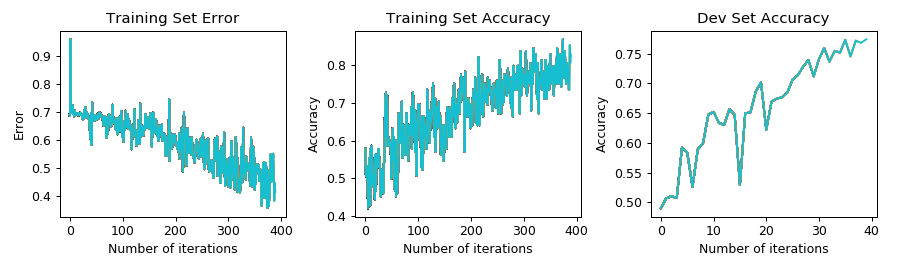

Training set error: 0.6863669304312434
Training set accuracy: 0.578125
Accuracy on dev set: 0.4904
Training set error: 0.6887261015432105
Training set accuracy: 0.578125
Accuracy on dev set: 0.5068
Training set error: 0.6976957481756159
Training set accuracy: 0.46875
Accuracy on dev set: 0.5104
Training set error: 0.6806562338677906
Training set accuracy: 0.5078125
Accuracy on dev set: 0.5072
Training set error: 0.6958436263864931
Training set accuracy: 0.609375
Accuracy on dev set: 0.5924
Training set error: 0.672891150441346
Training set accuracy: 0.5859375
Accuracy on dev set: 0.5836
Training set error: 0.6875551660642544
Training set accuracy: 0.4609375
Accuracy on dev set: 0.526
Training set error: 0.6806356724868492
Training set accuracy: 0.5546875
Accuracy on dev set: 0.5892
Training set error: 0.6646013870381886
Training set accuracy: 0.640625
Accuracy on dev set: 0.5996
Training set error: 0.6208172942340199
Training set accuracy: 0.7265625
Accuracy on dev set: 0.6472
Training

Training set error: 0.593876587022526
Training set accuracy: 0.7109375
Accuracy on dev set: 0.622
Training set error: 0.5674174219531123
Training set accuracy: 0.734375
Accuracy on dev set: 0.6692
Training set error: 0.5407361275826218
Training set accuracy: 0.765625
Accuracy on dev set: 0.6744
Training set error: 0.5539230747761756
Training set accuracy: 0.71875
Accuracy on dev set: 0.6764
Training set error: 0.5437992178781317
Training set accuracy: 0.7578125
Accuracy on dev set: 0.6844
Training set error: 0.567804062201301
Training set accuracy: 0.7265625
Accuracy on dev set: 0.7064
Training set error: 0.495272280329586
Training set accuracy: 0.7890625
Accuracy on dev set: 0.7136
Training set error: 0.49622326356827895
Training set accuracy: 0.7734375
Accuracy on dev set: 0.728
Training set error: 0.6044755036438137
Training set accuracy: 0.7109375
Accuracy on dev set: 0.7392
Training set error: 0.44575624614349474
Training set accuracy: 0.7734375
Accuracy on dev set: 0.7116
Trainin

In [17]:
parameters = train_model(X_train,Y_train,X_test[:2500],Y_test[:,:2500],num_epochs=2, batch_size=128,lambd=0,
                         learning_rate=1e-2,num_hidden_units=128,parameters=None, optimiser="adam")

<IPython.core.display.Javascript object>


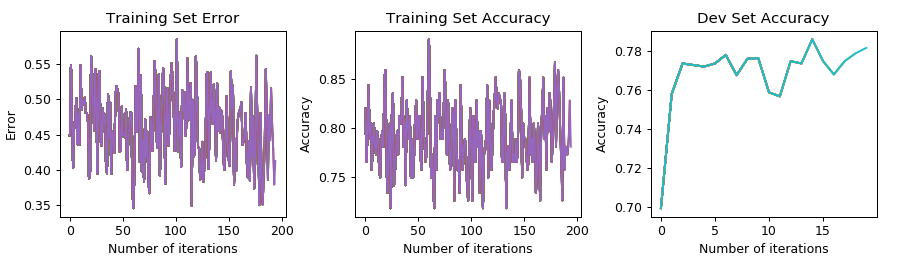

Training set error: 0.4487467098439568
Training set accuracy: 0.8203125
Accuracy on dev set: 0.6996
Training set error: 0.5477672385559325
Training set accuracy: 0.7734375
Accuracy on dev set: 0.758
Training set error: 0.5607654579352479
Training set accuracy: 0.7578125
Accuracy on dev set: 0.7736
Training set error: 0.43422937308796894
Training set accuracy: 0.796875
Accuracy on dev set: 0.7728
Training set error: 0.4550392381738644
Training set accuracy: 0.8046875
Accuracy on dev set: 0.772
Training set error: 0.4491796799454817
Training set accuracy: 0.8125
Accuracy on dev set: 0.7736
Training set error: 0.34583758776459494
Training set accuracy: 0.890625
Accuracy on dev set: 0.778
Training set error: 0.383113813874183
Training set accuracy: 0.8359375
Accuracy on dev set: 0.7676
Training set error: 0.5535530628087391
Training set accuracy: 0.7578125
Accuracy on dev set: 0.776
Training set error: 0.37995233619516083
Training set accuracy: 0.84375
Accuracy on dev set: 0.7764
Training 

In [22]:
parameters = train_model(X_train,Y_train,X_test[:2500],Y_test[:,:2500],num_epochs=1, batch_size=128,lambd=0,
                         learning_rate=1e-2,num_hidden_units=128,parameters=parameters, optimiser="adam")

The training/dev set accuracy should be close to 80% and in the example above we can see the dev set accuracy is 78% - we could potentially train the model for more epochs and decrease the learning rate for these subsequent epochs to achieve an even better performance.

However, let's see how the model performs on the test set - again, for computational efficiency we will only sample 3000 other reviews (the notebook kernel dies if we try to sample 12500).
Here we can see the test set accuracy is 80.1% - showing that the model has neither overfitted to the dev nor the test set.

In [23]:
y_pred, caches = forward_prop(X_test[3000:6000], parameters)

In [24]:
accuracy(y_pred,Y_test[:,3000:6000])

0.8013333333333333

Great! So let's sample a review from the test set and the corresponding prediction by the model. 
Note the file name also has a rating out of 10 after the underscore - here it is 8/10.

In [25]:
def predict(test_reviews, y_pred):
    i = np.random.randint(0,len(list(test_reviews)))
    with open(test_reviews[i], 'r') as f:
        print(test_reviews[i])
        for lines in f:
            print(lines)
    print("\n \nThe prediction of the model was: " + str(y_pred[:,i]))

In [26]:
predict(test_reviews[3000:6000], y_pred)

aclImdb/test//pos/2859_8.txt
Neil LaBute takes a dramatic turn from his first two films, In The Company of Men & Your Friends and Neighbors, with this funny and original thriller/comedy/road movie. When Betty (Renee Zellwegger) witnesses the brutal murder of her no-good husband (Aaron Eckhart), she develops a bizarre sort of amnesia, and flees in his car, not knowing that there is large stash of drugs in the trunk. Morgan Freeman and Chris Rock are the hit men who follow her.<br /><br />What Betty is chasing, besides a new beginning (although she can't remember the old life) is her beloved, Dr. David Ravell (Greg Kinnear). Only problem: Dr. David isn't real, he's a soap opera character on the show `A Reason To Love' and he's really an egotistical actor named George McCord.<br /><br />To say any more regarding what develops would be too much, but Nurse Betty is certainly original. Its hit men are, like the hired killers of Pulp Fiction, are violent yet philosophical, its take on soap op